In [ ]:
pip install --upgrade pip

In [ ]:
pip install tensorflow[and-cuda]

In [ ]:
pip install librosa

In [ ]:
pip install --update pip

In [ ]:
pip install keras

In [ ]:
pip install soundfile

# I. Creation of the database (training, test, evaluation dataset):

In [52]:
import numpy as np
import soundfile as sf
import IPython 
import random as rd
import os
import librosa
import matplotlib.pyplot as plt

In [ ]:
import keras

## A. Gathering signals data:

In [3]:
#Not perfect: here we only select datas from 1st folders.
def get_files_from_directories(path_data_folder = "./data"):
    list_audio_files = [path_data_folder]
    while os.path.isdir(list_audio_files[0]):
        origin_dir = list_audio_files[0]
        list_files_dir = os.listdir(origin_dir)
        list_audio_files = [origin_dir + "/" + list_files_dir[i] for i in range(len(list_files_dir))]
    print(f"We found {len(list_audio_files)} files")
    return list_audio_files

In [ ]:
# Utile pour écouter l'audio : IPython.display.Audio(signal_test , rate = sample_rate)

In [4]:
list_audio_files = get_files_from_directories()

We found 16 files


In [5]:
signal_test_0 , sr0 = sf.read(list_audio_files[0])
signal_test_1 , sr1 = sf.read(list_audio_files[1])
print(f"sample_rate_0 = {sr0} , sample_rate_1 = {sr1}")

sample_rate_0 = 16000 , sample_rate_1 = 16000


In [7]:
IPython.display.Audio(signal_test_0, rate = sr1)

## B. Creating noisy signals

In [143]:
# Chose a random moment in the noise
# UN RANDOM DANS CETTE FONCTION
def random_noise_start(noise):
    noise_resize = np.resize(noise, 2 * len(noise))
    random_start = rd.randint(0,len(noise))
    new_noise = noise_resize[random_start : random_start + len(noise)]
    return new_noise

In [144]:
# make a superposition of noises. 
# UN RANDOM DANS CETTE FONCTION
def create_superpose_noise( noise , random_nb_superposition = True, nb_superposition = None):
    if random_nb_superposition:
        nb_superposition = rd.randint(1,4)
    print(f"We used a superposition of {nb_superposition} noise(s)")

    superpose_noise = random_noise_start(noise)
    for i in range(nb_superposition-1):
        superpose_noise += random_noise_start(noise)
    superpose_noise = (1/nb_superposition)*superpose_noise
    return superpose_noise

In [146]:
def compute_power(signal):
    signal_stft = librosa.stft(signal)
    pw_signal = np.sum(np.abs(signal_stft**2))
    return pw_signal

In [157]:
def compute_rsb(signal, noise):
    pw_signal = compute_power(signal)
    pw_noise = compute_power(noise)
    rsb = pw_signal/pw_noise
    return rsb

In [158]:
def create_noisy_signal(clean_audio,noise, RSB = 0.7, random_nb_superposition = True, nb_superposition = None):
    superpose_noise = create_superpose_noise(noise,random_nb_superposition = random_nb_superposition, nb_superposition = nb_superposition)
    RSB_default = compute_rsb(clean_audio,superpose_noise)
    alpha = np.sqrt(RSB_default/RSB)
    noisy_signal = clean_audio + alpha*np.resize(superpose_noise, len(clean_audio))
    print(f"We have a rsb of {compute_rsb(clean_audio,alpha*superpose_noise)} for a noise's attenuation equals to alpha = {alpha}" )
    return noisy_signal, superpose_noise

**Adding noise:** We want to add different noises on our audio
- 1: Chose a random moment in the noise 
- 2: Make a superposition of the noises 
- 3: Chose an alpha coef to the noise
- 4: Chose a chosen RSB,by selecting alpha coef.


In [169]:
path_noise_file = "./data/noise.wav"
noise,samplerate = sf.read(path_noise_file)
print(samplerate, noise.shape)

16000 (3763687,)


In [165]:
noisy_signal_test0 , noise_0 = create_noisy_signal(signal_test_0,noise, RSB = 0.9)

We used a superposition of 1 noise(s)
We have a rsb of 0.8999999999999996 for a noise's attenuation equals to alpha = 0.1617744555388175


In [166]:
#test 
IPython.display.Audio(signal_test_0, rate = sr0)

In [167]:
IPython.display.Audio(noisy_signal_test0, rate = sr0)

In [168]:
IPython.display.Audio(noise_test0, rate = sr0)

# II. Implementation of the training 

In [ ]:
def compute_abs_squared_stft(signal):
    signal_stft = librosa.stft(signal)
    signal_stft_abs = np.abs(signal_stft)**2
    return signal_stft_abs

In [195]:
def display_spectogramm(signal):
    signal_stft_abs = compute_abs_squared_stft(signal)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(librosa.amplitude_to_db(signal_stft_abs,ref=np.max),y_axis='log', x_axis='time', ax=ax)
    ax.set_title('Power spectrogram')
    fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [200]:
def get_best_mask(signal,noise):
    signal_stft_abs = compute_abs_squared_stft(signal)
    noise_stft_abs = compute_abs_squared_stft(noise)
    mask = np.zeros(np.shape(signal_stft_abs))
    for i in range (np.shape(signal_stft_abs)[0]):
        for j in range(np.shape(signal_stft_abs)[1]):
            if (signal_abs[i,j] > noise_stft_abs[i,j]):
                mask[i,j] = 1
    return mask

## I. Prepare the inputs:
- 1: Compute the STFT of the clean_signal and the noisy_signal 
- 2: Compute the absolute of the squared of the stft
- 3: Go to log scale ?? Linear? 

In [197]:
signal_stft_abs_squared = compute_abs_squared_stft(signal_test_0)
noisy_signal_stft_abs_squared = compute_abs_squared_stft(noisy_signal_0)
noise_stft_abs_squared = compute_abs_squared_stft(noise_0)

## Test with the best theorical mask:

In [211]:
# DIDNT WORKED 
#problem au niveau de la definition de ax. (à la base fig, ax = plt.subplots(), mais là en voulant utiliser plt.subplot je suis bloqué.)

def display_spectogramm_comparison(signal,noisy_signal,noise):
    signal_stft_abs_squared = compute_abs_squared_stft(signal)
    noisy_signal_stft_abs_squared = compute_abs_squared_stft(noisy_signal)
    noise_stft_abs_squared = compute_abs_squared_stft(noise)
    mask = get_best_mask(signal,noise)
    best_denoise_signal = signal_stft_abs_squared * mask
    fig , ax = plt.subplots(1,3,1)
    #fig ,ax = plt.subplots()
    img = librosa.display.specshow(librosa.amplitude_to_db(signal_stft_abs_squared,ref=np.max),y_axis='log', x_axis='time', ax=ax)
    #ax.set_title('Power spectrogram')
    fig.colorbar(img, ax=ax, format="%+2.0f dB")

## II. Make the training:
- 4: Put in place a Deep Neural Network  (Which one) 
- 5: Compute the loss function  (Which one)
- 6: lets make the minimization . (Which one)

In [135]:
# Creation of the mask. if /s/^2 > /u/^2 M = 1, 0 otherwise
signal_abs = np.abs(signal_stft_test_0)**1
noise_abs = np.abs(noisy_signal_stft_0)**1
mask = np.zeros(np.shape(signal_abs))
test = 0
for i in range (np.shape(signal_abs)[0]):
    for j in range(np.shape(signal_abs)[1]):
        if (signal_abs[i,j] > noise_abs[i,j]):
            test+=1
            mask[i,j] = 1
print(test)

34536


In [136]:
test = signal_abs - mask

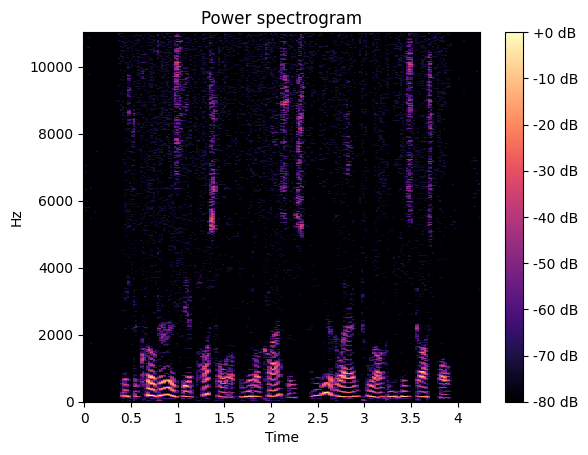

In [137]:
display_spectogramm(test)

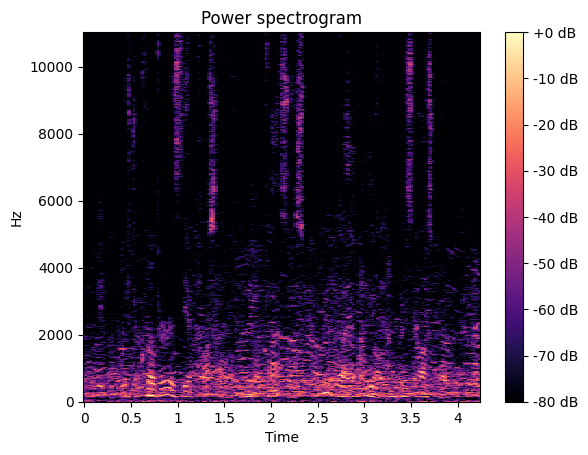

In [138]:
display_spectogramm(noise_abs)

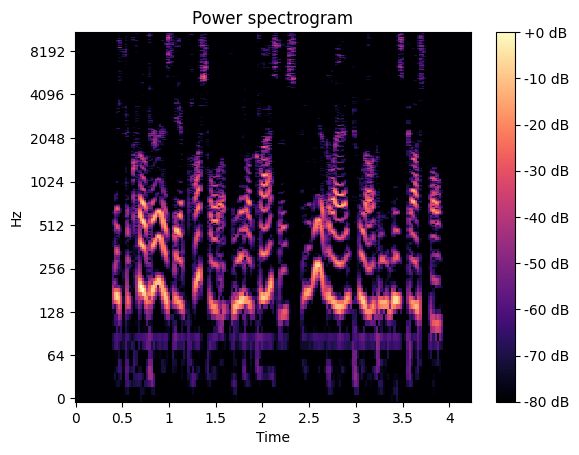

In [55]:
display_spectogramm(signal_abs)

# test concluant, il faut maintenant mettre en place une fonction de coût!
Ensuite mettre en place les datasets 
enfin créer une première architecture de réseau de neurones. 